In [1]:
from arc import *
from time import time
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
%matplotlib inline

## compare interaction matrices obtained via the different approaches and computation speed for a single C6 calculation

In [2]:
# set atom properties
atom = Cesium()
n, l, j, mj1 = 63, 0, 0.5, 0.5
nn, ll, jj, mj2 = 90, 2, 2.5, 0.5

# set calculation properties
nrange, dE = 10, 1*1e12
stateHop = False
theta, phi = np.pi/4,np.pi/4
times = []

# initialise PairStateInteractions class instance
calc = PairStateInteractions(atom, n, l, j, nn, ll, jj, m1=mj1, m2=mj2, interactionsUpTo=1)


# calculate via all perturbative approach
times.append(time())
C6_pert = calc.getC6perturbatively(theta, phi, nrange, dE, degeneratePerturbation=False)
times.append(time())

# calculate same but via angular channel approach
times.append(time())
C6_lj, C6hop_lj = calc.getC6PerturbativelyAngularChannel(theta, phi, nrange, dE, degeneratePerturbation=False)
times.append(time())


# print abs. difference
print('abs. difference between C6 value from perturbative and angular channel approach: {:.1f}'.format(np.abs(C6_pert-C6_lj)))
# print timings
print('\n time requirements in sec.:\n\t perturbative: {:.1f} \n\t angular channels: {:.1f}'.format(times[1]-times[0], times[3]-times[2]))

abs. difference between C6 value from perturbative and angular channel approach: 0.0

 time requirements in sec.:
	 perturbative: 0.6 
	 angular channels: 0.9


## compare calculation speed for one pair state and different set of angles

The difference in calculation speed is due to the perturbative calculation having to re-run the full computations for all set of angles while the angular channel approach has to compute the angular channel values once and then simply reconstructs C6 value at different interatomic orientations.

It is even faster to load precalculated angular channel values from file if precalculated data exists, this method is shown further down.

calculation of 5 values via perturbative approach: 2.8 s
calculation of 501 values via perturbative approach: 3.1 s


[]

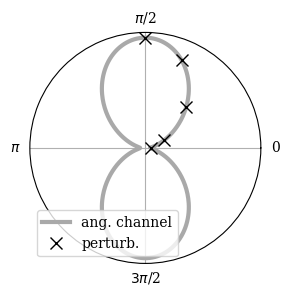

In [3]:
# set atom properties
atom = Cesium()
n, l, j, mj1 = 63, 0, 0.5, j
nn, ll, jj, mj2 = 90, 2, 2.5, jj

# set calculation propreties
nrange, dE = 10, 1*1e12
stateHop = False

# set theta values
theta_pert = np.linspace(0, np.pi/2, 5)
theta_lj = np.linspace(0, np.pi*2, 501)
phi = 0

# time array
times = []

# initialise PairStateInteractions class instance
calc = PairStateInteractions(atom, n, l, j, nn, ll, jj, m1=mj1, m2=mj2, interactionsUpTo=1)

# perturbative calculation
C6_pert = np.zeros_like(theta_pert)
times.append(time())
for i, theta in enumerate(theta_pert):
    C6_pert[i] = calc.getC6perturbatively(theta, phi, nrange, dE, degeneratePerturbation=False)
times.append(time())
print('calculation of {:.0f} values via perturbative approach: {:.1f} s'.format(len(theta_pert), times[1]-times[0]))

# angular channel code
times.append(time())
C6_lj = calc.getC6Perturbatively_anglePairs([(theta, phi) for theta in theta_lj], nrange, dE, degeneratePerturbation=False, returnInteractionMatrix=False)[0]
times.append(time())
print('calculation of {:.0f} values via perturbative approach: {:.1f} s'.format(len(theta_lj), times[3]-times[2]))


# plot
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1, projection='polar')

# plot 
ax.plot(theta_lj, C6_lj, color='darkgray', linewidth=3, label='ang. channel')
ax.plot(theta_pert, C6_pert, color='black', linestyle='none', marker='x', ms=9, label='perturb.')
ax.legend(bbox_to_anchor=(0,0), loc=3)
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'$3\pi$/2'])
ax.set_yticks([])

## save angular channel values to file and load from file

These functions allow the user to generate the angular channel precalc files by setting the calculation parameters and calling the function. In case of an update of any atomic properties or functions, such as quantum defect, energy level calculations etc., the user can use these functions to trigger a new calculation of the precalc files themselves.

The saveLJ function includes a header that stores all relevant file information such as atomic states, calculation settings, angular channels, ...

The loadLJfromFile function reads out the header as well as the data and provides the information.

data was successfully saved to file testdata.txt.
time requirement for calculation of 121 pair state data: 5.9 s.
time taken to load precalculated data: 0.0 s
{'atom 1': 'Rb85', 'atom 2': 'Cs133', 'nRange': 10, 'energyDelta': '1000000000000.0', 'stateHopping': 'False', 'nValueRange': [20, 30], 'interactionsUpTo': '1'}
[[0.0, 0.5, 2.0, 2.5, 1.0, 0.5, 1.0, 1.5, 0.0, 0.5, 2.0, 2.5], [0.0, 0.5, 2.0, 2.5, 1.0, 0.5, 3.0, 2.5, 0.0, 0.5, 2.0, 2.5], [0.0, 0.5, 2.0, 2.5, 1.0, 0.5, 3.0, 3.5, 0.0, 0.5, 2.0, 2.5], [0.0, 0.5, 2.0, 2.5, 1.0, 1.5, 1.0, 1.5, 0.0, 0.5, 2.0, 2.5], [0.0, 0.5, 2.0, 2.5, 1.0, 1.5, 3.0, 2.5, 0.0, 0.5, 2.0, 2.5], [0.0, 0.5, 2.0, 2.5, 1.0, 1.5, 3.0, 3.5, 0.0, 0.5, 2.0, 2.5]]
(11, 11, 8)


Text(0.5, 0.98, 'Channel no.')

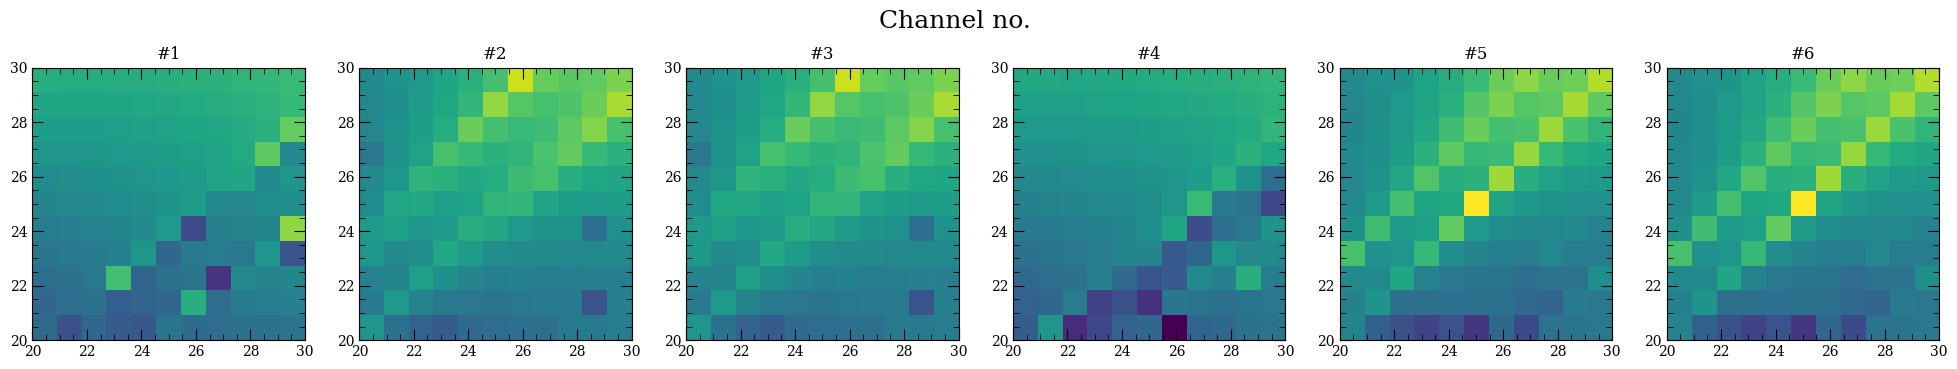

In [4]:
# set all relevant params
filename = 'testdata.txt'

# atom properties
nMin, nMax = 20, 30
l1, j1, s1 = 0, 0.5, 0.5
l2, j2, s2 = 2, 2.5, 0.5
atom1, atom2 = Rubidium(), Cesium()

# calculation properties
nRange = 10
energyDelta = 1e12
stateHopping = False

# initialise calc.class, the initial state parameters do not matter as we will later pass our range of interest to the .saveLJ function
calc = PairStateInteractions(Cesium(), 20, 0,0.5, 20,0,0.5, m1=0.5, m2=0.5, interactionsUpTo=1)



## calculate data and save in file
t1 = time()
calc.saveLJ(filename, [nMin, nMax], [l1, j1, s1, atom1], [l2, j2, s2, atom2], nRange, energyDelta, stateHopping=False)
t2 = time()
print('time requirement for calculation of {:.0f} pair state data: {:.1f} s.'.format((nMax-nMin+1)**2, t2-t1))



## load data from file
t1 = time()
atomInfos, coupledStates, data = calc.loadLJfromFile(filename)
data = np.reshape(data, ((nMax-nMin+1), (nMax-nMin+1), len(coupledStates)+2))
t2 = time()
print('time taken to load precalculated data: {:.1f} s'.format(t2-t1))

# print file metadata
print(atomInfos)
print(coupledStates)
print(np.shape(data))

# plot data
fig, ax = plt.subplots(1, len(coupledStates), figsize=(4.1*len(coupledStates),4))
for i, path in enumerate(coupledStates):
    ax[i].imshow(np.log10(np.abs(data[:,:, i+2])), origin='lower', extent=[nMin, nMax, nMin, nMax],
                 vmin=np.min(np.log10(np.abs(data[:,:,2:]))), vmax=np.max(np.log10(np.abs(data[:,:,2:]))))
    ax[i].set_title('#'+str(i+1))
fig.suptitle('Channel no.', fontsize=18)

## look behind the scenes - how does angular channel code work?
Effectively, the angular channel code runs the perturbative calculation to compute the angular channel values once and then implements the angular orientation. One can also do this manually by calculating the angular channel strengths, then calculate the full interaction matrix at theta = 0 and finally rotate the interaction matrix to the actual relative interatomic orientation with Wigner-D matrices.

In the following, we will go through the whole angular momentum channel procedure in detail to demonstrate the steps that happen behind the scenes in the functions. Note, though, that this only shows the case where the atoms return to their initial state.

[]

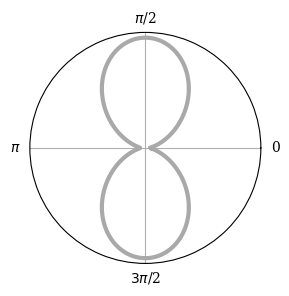

In [5]:
# set atom properties
atom1, atom2 = Cesium(), Cesium()
n, l, j, mj1, s1 = 63, 0, 0.5, j, 0.5
nn, ll, jj, mj2, s2 = 90, 2, 2.5, jj, 0.5

# set calculation propreties
nrange, dE = 10, 1*1e12
stateHop = False

# set angles
theta_lj = np.linspace(0, np.pi*2, 501)
phi = np.pi/4

# initialise PairStateInteractions class instance
calc = PairStateInteractions(atom, n, l, j, nn, ll, jj, m1=mj1, m2=mj2, interactionsUpTo=1)


## find all coupled angular channels
coupledStates = calc._findAllCoupledAngularMomentumStates(l,j,s1, ll,jj,s2, stateHopping=stateHop)
if coupledStates == []:
    raise ValueError("No interaction pathways found for the specified conditions.")


## calculate angular channel values, together with channel information
channelData = []
for pathway in coupledStates:
    V_lj = calc._calcLJcontribution_allParamsFree(pathway, [n,s1, atom1], [nn,s2, atom2],
                                                  nrange, dE, stateHop, interactionsUpTo=1)
    channelData.append([*pathway, V_lj])

    
## for all channels, construct the channel's interaction matrix and sum up to get total Imat
# this can also be done by feeding the channelData list into the _getPerturbativeC6Matrix_lj function
#Imat = calc._getPerturbativeC6Matrix_lj(channelData)

Imat = 0
# iterate through channels
for vals in channelData:
    # construct mj-resolved transition matrix for first and second dipole transition
    d1 = calc._getd(*vals[0:8])
    d2 = calc._getd(*vals[4:12])
    # construct mj-resolved transition matrix for full process
    D = d2.dot(d1)
    # add channel to overall Imat
    Imat += vals[-1]*D


## Now that we have the interaction matrix at theta = 0, rotate to desired angles 
## via Wigner matrices and save C6 value from that angle for given (mj1, mj2) pair

C6 = []

# get array indexing the 2-atom composite state in (mj1, mj2) basis
compState = compositeState(singleAtomState(j, mj1), singleAtomState(jj, mj2)).T
# alternatively: get index via mjInd = (j+mj1)*(jj+mj2) and then select via index rather than by state mul.

# iterate through angles
for theta in theta_lj:
    # Wigner D matrix allows calculations with arbitrary orientation of the two atoms
    wgd = WignerDmatrix(theta, phi)
    angRotationMatrix = np.kron(wgd.get(j).toarray(),wgd.get(jj).toarray())
                    
    # rotate Imat's into correct basis for angles theta, phi (angle1, angle2)
    Imat_rot = angRotationMatrix.dot(Imat.dot(angRotationMatrix.conj().T))

    # get C6 value for the correct initial and final (mj1, mj2) combination
    C6val = np.real(compState.dot(Imat_rot.dot(compState.T)))[0][0]
    C6.append(C6val)


## plot results
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1, projection='polar')

# plot 
ax.plot(theta_lj, C6, color='darkgray', linewidth=3)
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'$3\pi$/2'])
ax.set_yticks([])

## study composition of C6 into angular channels
We will do the same procedure as above, but this time resolve the different angular channels so that one can see how the resulting C6 is composed of a sum of the different angular channels.

angular channels (l, j, ll, jj each for init, interm. fin) and associated channel value C^(lj)
(0, 0.5, 2, 2.5, 1, 0.5, 1, 1.5, 0, 0.5, 2, 2.5) with C^(lj) = 100.892 GHz um^6
(0, 0.5, 2, 2.5, 1, 0.5, 3, 2.5, 0, 0.5, 2, 2.5) with C^(lj) = 46.497 GHz um^6
(0, 0.5, 2, 2.5, 1, 0.5, 3, 3.5, 0, 0.5, 2, 2.5) with C^(lj) = 46.497 GHz um^6
(0, 0.5, 2, 2.5, 1, 1.5, 1, 1.5, 0, 0.5, 2, 2.5) with C^(lj) = 36.874 GHz um^6
(0, 0.5, 2, 2.5, 1, 1.5, 3, 2.5, 0, 0.5, 2, 2.5) with C^(lj) = -74.288 GHz um^6
(0, 0.5, 2, 2.5, 1, 1.5, 3, 3.5, 0, 0.5, 2, 2.5) with C^(lj) = -74.288 GHz um^6

 max. |C6| value for mj1=0.5 and mj2=2.5 is 1.381 GHz um^6


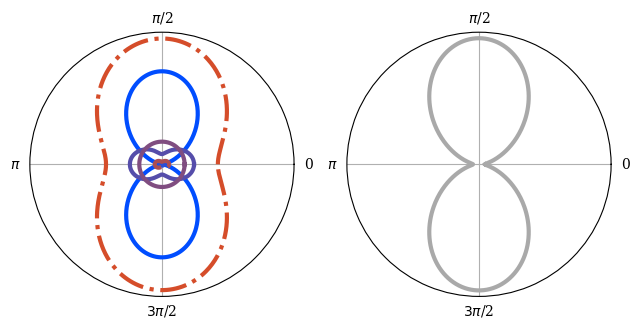

In [6]:
# set atom properties
atom1, atom2 = Cesium(), Cesium()
n, l, j, mj1, s1 = 63, 0, 0.5, 0.5, 0.5
nn, ll, jj, mj2, s2 = 90, 2, 2.5, 2.5, 0.5

# set calculation propreties
nrange, dE = 10, 1*1e12
stateHop = False

# set angles
theta_lj = np.linspace(0, np.pi*2, 501)
phi = np.pi/4

# initialise PairStateInteractions class instance
calc = PairStateInteractions(atom, n, l, j, nn, ll, jj, m1=mj1, m2=mj2, interactionsUpTo=1)


## find all coupled angular channels
coupledStates = calc._findAllCoupledAngularMomentumStates(l,j,s1, ll,jj,s2, stateHopping=stateHop)
if coupledStates == []:
    raise ValueError("No interaction pathways found for the specified conditions.")


## calculate angular channel values, together with channel information
channelData = []
print('angular channels (l, j, ll, jj each for init, interm. fin) and associated channel value C^(lj)')
for pathway in coupledStates:
    V_lj = calc._calcLJcontribution_allParamsFree(pathway, [n,s1, atom1], [nn,s2, atom2],
                                                  nrange, dE, stateHop, interactionsUpTo=1)
    channelData.append([*pathway, V_lj])
    print(pathway, 'with C^(lj) = {:.3f} GHz um^6'.format(V_lj))

    
## for all channels, construct the channel's own Imat and plot. Later, sum up all channel's Imats to get overall C6, plot

# create figure and axis instance
fig = plt.figure(figsize=(7.5, 3.5))
gs = GridSpec(1,2, wspace=0.2)
ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i], projection='polar'))

# get array indexing the 2-atom composite state in (mj1, mj2) basis
compState = compositeState(singleAtomState(j, mj1), singleAtomState(jj, mj2)).T
# alternatively: get index via mjInd = (j+mj1)*(jj+mj2) and then select via index rather than by state mul.

# compute Wigner-D matrices for specified angles to avoid having to compute them multiple times
wigD = np.zeros((int((2*j+1)*(2*jj+1)),int((2*j+1)*(2*jj+1)),len(theta_lj)), dtype=complex)
for i, theta in enumerate(theta_lj):
    wgd = WignerDmatrix(theta, phi)
    wigD[:,:,i] = np.kron(wgd.get(j).toarray(), wgd.get(jj).toarray())

C62 = np.zeros(len(theta_lj))

# iterate through channels
for i, vals in enumerate(channelData):
    # construct mj-resolved transition matrix for first and second dipole transition
    d1 = calc._getd(*vals[0:8])
    d2 = calc._getd(*vals[4:12])
    # construct full mj-resolved transition matrix for channel
    Imat_lj = vals[-1]*d2.dot(d1)
    
    C6_lj = np.zeros(len(theta_lj))
    
    # iterate through angles
    for k, theta in enumerate(theta_lj):
        # get correct Wigner-D matrix
        angRotationMatrix = wigD[:,:,k]
                    
        # rotate Imat's into correct basis for angles theta, phi (angle1, angle2)
        Imat_rot = angRotationMatrix.dot(Imat_lj.dot(angRotationMatrix.conj().T))

        # get C6 value for the correct initial and final (mj1, mj2) combination
        C6val = np.real(compState.dot(Imat_rot.dot(compState.T)))[0][0]
        C6_lj[k] = C6val

    # plot into polar plot
    ax[0].plot(theta_lj, np.where(C6_lj > 0, C6_lj, np.nan), ls='solid', lw=3, color=(i/len(channelData), 0.3, 1-i/len(channelData))) # >0: solid line
    ax[0].plot(theta_lj, np.where(C6_lj < 0, -C6_lj, np.nan), ls='dashdot', lw=3, color=(i/len(channelData), 0.3, 1-i/len(channelData))) # <0: dashdot
    
    
    #add to overall C6
    C62 += C6_lj

# print max. C6 value
print('\n max. |C6| value for mj1={:.1f} and mj2={:.1f} is {:.3f} GHz um^6'.format(mj1, mj2, np.max(np.abs(C6))))


## plot overall C6
ax[1].plot(theta_lj, C62, color='darkgray', linewidth=3)
for axis in ax:
    axis.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'$3\pi$/2'])
    axis.set_yticks([])

#### For those who want to play around with angular channels to learn more:
The function _calcLJcontribution_allParamsFree allows the user complete freedom over all parameters that could be varied.